## Статистический анализ данных
## Проект для телеком компании

### Загрузка и предобработка данных (Шаг 1)

In [949]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st

Далее поочерёдно импортируем датасеты и оцениваем их. Для каждого датасета напечатаем первые 10 строк и посмотрим информацию. Проверим дубликаты.

In [950]:
# Загрузим звонки
data_calls = pd.read_csv('/Users/peterefimov/Documents/datasets/calls.csv')
data_calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [951]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В данных о звонках есть значения с длительностью звонка 0.0 минут. В задании указано, что любой звонок длительностью хоть 1 секунду округляется до минуты. Значит, звонка с длительность 0.0 минут фактически не состоялось. Это может быть пропущенный, сброшенный звонок, случайный набор номера или что-то ещё. Вряд ли такой звонок можно считать сознательно инициированным или принятым пользователем. Так как такой звонок не расходует лимит минут и не может быть оплачен сверх лимита, для данного исследования можно считать такие звонки неактуальными. 

Избавимся от этих звонков.

In [952]:
# Переприсваиваем данные с условием, что длительность звонка не равна 0.0 минут
data_calls = data_calls.query('duration != 0.0')
data_calls.head(10)

,id,call_date,duration,user_id
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
10,1000_10,2018-08-22,5.03,1000
11,1000_11,2018-05-28,18.82,1000
12,1000_12,2018-07-05,2.02,1000
13,1000_13,2018-09-29,7.15,1000
14,1000_14,2018-12-11,9.13,1000


Согласно заданию звонки должны округляться в большую сторону до целой минуты. Применим округление вверх и заодно переведём данные в int для упрощения дальнейших вычислений.

In [953]:
data_calls.loc[:, 'duration'] = data_calls.loc[:, 'duration'].apply(np.ceil).astype('int')

# Выведем первые строки и проверим результат
print(data_calls.head(5))
print(data_calls.info())

       id   call_date  duration  user_id
2  1000_2  2018-06-11         3     1000
3  1000_3  2018-09-21        14     1000
4  1000_4  2018-12-15         6     1000
7  1000_7  2018-08-22        19     1000
8  1000_8  2018-09-15        19     1000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         162994 non-null  object
 1   call_date  162994 non-null  object
 2   duration   162994 non-null  int64 
 3   user_id    162994 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.2+ MB
None


In [954]:
# Загрузим данные об интернет-трафике

data_internet = pd.read_csv('/Users/peterefimov/Documents/datasets/internet.csv')
data_internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [955]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Согласно заданию использованные мегабайты должны округляться в большую сторону до целого числа. Применим округление вверх и заодно переведём данные в int для упрощения дальнейших вычислений.

In [956]:
data_internet.loc[:, 'mb_used'] = data_internet.loc[:, 'mb_used'].apply(np.ceil).astype('int')

# Выведем первые строки и проверим результат
print(data_internet.head(5))
print(data_internet.info())

   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0      113   2018-11-25     1000
1           1  1000_1     1053   2018-09-07     1000
2           2  1000_2     1198   2018-06-25     1000
3           3  1000_3      551   2018-08-22     1000
4           4  1000_4      303   2018-09-24     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    149396 non-null  int64 
 1   id            149396 non-null  object
 2   mb_used       149396 non-null  int64 
 3   session_date  149396 non-null  object
 4   user_id       149396 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 5.7+ MB
None


In [957]:
# Загрузим данные о смс-сообщениях

data_messages = pd.read_csv('/Users/peterefimov/Documents/datasets/messages.csv')
data_messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [958]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [959]:
data_tariffs = pd.read_csv('/Users/peterefimov/Documents/datasets/tariffs.csv')
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [960]:
data_users = pd.read_csv('/Users/peterefimov/Documents/datasets/users.csv')
data_users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [961]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [962]:
print(data_calls.duplicated().sum())
print(data_internet.duplicated().sum())
print(data_messages.duplicated().sum())
print(data_users.duplicated().sum())

0
0
0
0


Внешне данные выглядят качественными: нет пропущенных значений, нет явных дубликатов. 

Пропуски в данных churn_date объясняется тем, что тариф ещё действует - это указано в задании.

Теперь переведём даты в формат datetime:

In [963]:
data_calls.loc[:, 'call_date'] = pd.to_datetime(
    data_calls['call_date'],
    format='%Y-%m-%d')

data_internet.loc[:, 'session_date'] = pd.to_datetime(
    data_internet['session_date'],
    format='%Y-%m-%d')

data_messages.loc[:, 'message_date'] = pd.to_datetime(
    data_messages['message_date'],
    format='%Y-%m-%d')

data_users.loc[:, 'reg_date'] = pd.to_datetime(
    data_users['reg_date'],
    format='%Y-%m-%d')

data_users.loc[:, 'churn_date'] = pd.to_datetime(
    data_users['churn_date'],
    format='%Y-%m-%d')

### Вывод по предобработке (Шагу 1)

1. Данные загружены.
2. Проверены дубликаты.
3. Изучены пропуски.
4. Удалены нулевые значения, не влияющие не исследование.
5. Данные приведены к нужным типам.
6. Нужные параметры округлены согласно заданию.

### Подготовка данных и расчёт новых значений (Шаг 2)

Так как требуется помесячный анализ, выделим столбец "месяц" для каждого набора данных

In [964]:
data_calls.loc[:, 'month'] = data_calls['call_date'].dt.month
data_internet.loc[:, 'month'] = data_internet['session_date'].dt.month
data_messages.loc[:, 'month'] = data_messages['message_date'].dt.month

# Проверим образование нового столбца:
data_calls.head()

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9


Теперь посчитаем недостающие величины:

In [965]:
# Группируем таблицу звонков по пользователю и месяцу, считаем количество звонков 
# и длительность звонков по месяцам,
# для некоторой логичности вывода информации отсортируем по пользователю и по месяцу.

calls_grouped = (data_calls
                 .groupby(['user_id','month'])
                 .agg({'id':'count','duration':'sum'})
                 .sort_values(by=['user_id','month'])
              .reset_index())

calls_grouped.head(15)

,user_id,month,id,duration
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
5,1000,10,44,350
6,1000,11,37,338
7,1000,12,38,333
8,1001,11,45,430
9,1001,12,47,414


In [966]:
# Группируем таблицу сообщений по пользователю и месяцу, считаем количество сообщений.
# Для некоторой логичности вывода информации отсортируем по пользователю и по месяцу.

messages_grouped = (data_messages
                 .groupby(['user_id','month'])
                 .agg({'id':'count'})
                 .sort_values(by=['user_id','month'])
                 .reset_index())

messages_grouped.head(15)

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


In [967]:
# Группируем таблицу потраченного трафика по пользователю и месяцу, считаем суммарный трафик.
# Для некоторой логичности вывода информации отсортируем по пользователю и по месяцу.

internet_grouped = (data_internet
                 .groupby(['user_id','month'])
                 .agg({'mb_used':'sum'})
                 .sort_values(by=['user_id','month'])
                 .reset_index())

internet_grouped.head(10)

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
5,1000,10,14717
6,1000,11,14768
7,1000,12,9827
8,1001,11,18452
9,1001,12,14053


Теперь для расчёта выручки объединим необходимые данные в сводную таблицу.

In [968]:
user_calls = (data_users.merge(calls_grouped, 
                              on='user_id', 
                              how='outer'))

user_calls_messages = (user_calls.merge(messages_grouped, 
                                        on=['user_id','month'], 
                                        how='outer',
                                        suffixes=('_calls_count', '_messages_count')))

data = (user_calls_messages.merge(internet_grouped,
                                  on=['user_id','month'],
                                  how='outer'))
data.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,id_calls_count,duration,id_messages_count,mb_used
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,17.0,159.0,22.0,2256.0
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,28.0,172.0,60.0,23257.0
2,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,41.0,340.0,75.0,14016.0
3,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,42.0,408.0,81.0,14070.0
4,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,46.0,466.0,57.0,14581.0


In [969]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3222 entries, 0 to 3221
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            3222 non-null   int64         
 1   age                3176 non-null   float64       
 2   churn_date         189 non-null    datetime64[ns]
 3   city               3176 non-null   object        
 4   first_name         3176 non-null   object        
 5   last_name          3176 non-null   object        
 6   reg_date           3176 non-null   datetime64[ns]
 7   tariff             3176 non-null   object        
 8   month              3214 non-null   float64       
 9   id_calls_count     3168 non-null   float64       
 10  duration           3168 non-null   float64       
 11  id_messages_count  2717 non-null   float64       
 12  mb_used            3203 non-null   float64       
dtypes: datetime64[ns](2), float64(6), int64(1), object(4)
memory us

Обнаружили пропущенные значения в звонках, сообщениях и потраченном трафике. Это логично объясняется - абоненты могут в принципе не пользоваться какими-то услугами. Заменим эти пропуски на нули, чтобы сохранить для них расчёт выручки.

Также есть 46 абонентов с пропущенными именем, фамилией, городом и тарифом. Видимо, это результат ошибки при сборе данных, либо какие-то безымянные сим-карты или что-то подобное. Их количество невелико, к тому же, не зная их тарифа, мы не сможем правильно посчитать их выручку. Поэтому данные пропуски можно удалить.

In [970]:
data['id_calls_count'].fillna(0, inplace=True)
data['duration'].fillna(0, inplace=True)
data['id_messages_count'].fillna(0, inplace=True)
data['mb_used'].fillna(0, inplace=True)

data.dropna(subset = ['month', 'tariff'], inplace = True)

Теперь рассчитаем выручку по каждому абоненту. Для этого напишем фунцкию для расчёта в зависимости от тарифа.

In [971]:
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [972]:
# Считаю, что данные из таблицы data_tariffs в данном случае проще вписать вручную, чем делать ссылки на таблицу

def income_counter(row):
    
    messages_overdraft = 0
    traffic_overdraft  = 0
    minutes_overdraft  = 0
    
    if row['tariff'] == 'smart':
    
        messages_overdraft = row['id_messages_count'] - 50  
        if messages_overdraft < 0:
            messages_overdraft = 0    
            
        traffic_overdraft = row['mb_used'] - 15360    
        if traffic_overdraft < 0:
            traffic_overdraft = 0     
            
        minutes_overdraft = row['duration'] - 500
        if minutes_overdraft < 0:
            minutes_overdraft = 0

# Предположим, что тарификация идёт помегабайтная.             
# Цену одного перерасходованно мегабайта определим как цену гигабайта, разделённую на 1024. 
   
        income = 550 + (messages_overdraft*3) + (traffic_overdraft*200/1024) + (minutes_overdraft*3)
        return income
    
    elif row['tariff'] == 'ultra':
        
        messages_overdraft = row['id_messages_count'] - 1000    
        if messages_overdraft < 0:
            messages_overdraft = 0    
            
        traffic_overdraft = row['mb_used'] - 30720    
        if traffic_overdraft < 0:
            traffic_overdraft = 0     
            
        minutes_overdraft = row['duration'] - 3000
        if minutes_overdraft < 0:
            minutes_overdraft = 0
        
        income = 1950 + (messages_overdraft*1) + (traffic_overdraft*150/1024) + (minutes_overdraft*1)
        return income    

# Применим функцию к новому столбцу и округлим значение до 2 знаков, после запятой.
data['income'] = round(data.apply(income_counter,axis=1),2)
data.head(2)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,id_calls_count,duration,id_messages_count,mb_used,income
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,17.0,159.0,22.0,2256.0,1950.0
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,28.0,172.0,60.0,23257.0,1950.0


In [973]:
# Заменим названия столбцов с сообщениями и звонками
column_list = ['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff', 'month', 'calls_total', 'duration_total',
       'sms_total', 'mb_used', 'income']
data.columns = column_list
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3175
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3168 non-null   int64         
 1   age             3168 non-null   float64       
 2   churn_date      187 non-null    datetime64[ns]
 3   city            3168 non-null   object        
 4   first_name      3168 non-null   object        
 5   last_name       3168 non-null   object        
 6   reg_date        3168 non-null   datetime64[ns]
 7   tariff          3168 non-null   object        
 8   month           3168 non-null   float64       
 9   calls_total     3168 non-null   float64       
 10  duration_total  3168 non-null   float64       
 11  sms_total       3168 non-null   float64       
 12  mb_used         3168 non-null   float64       
 13  income          3168 non-null   float64       
dtypes: datetime64[ns](2), float64(7), int64(1), object(4)
me

Заменим вещественные числа на натуральные там, где это требуется.

In [974]:
data.loc[:, 'age'] = data.loc[:, 'age'].astype('int')
data.loc[:, 'month'] = data.loc[:, 'month'].astype('int')
data.loc[:, 'calls_total'] = data.loc[:, 'calls_total'].astype('int')
data.loc[:, 'duration_total'] = data.loc[:, 'duration_total'].astype('int')
data.loc[:, 'sms_total'] = data.loc[:, 'sms_total'].astype('int')
data.loc[:, 'mb_used'] = data.loc[:, 'mb_used'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3175
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3168 non-null   int64         
 1   age             3168 non-null   int64         
 2   churn_date      187 non-null    datetime64[ns]
 3   city            3168 non-null   object        
 4   first_name      3168 non-null   object        
 5   last_name       3168 non-null   object        
 6   reg_date        3168 non-null   datetime64[ns]
 7   tariff          3168 non-null   object        
 8   month           3168 non-null   int64         
 9   calls_total     3168 non-null   int64         
 10  duration_total  3168 non-null   int64         
 11  sms_total       3168 non-null   int64         
 12  mb_used         3168 non-null   int64         
 13  income          3168 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(7), object(4)
me

Количество ненулевых значений расчитанных величин совпадает с количеством ненулевых значений имени,
фамилии и тарифа. Нужным данным присвоен тип натуральных чисел. В общем, что и хотели получить. Вывожу на экран получившуюся сводную таблицу.

In [975]:
data.head(15)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_total,duration_total,sms_total,mb_used,income
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,17,159,22,2256,1950.00
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,28,172,60,23257,1950.00
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,41,340,75,14016,1950.00
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,42,408,81,14070,1950.00
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,46,466,57,14581,1950.00
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10,44,350,73,14717,1950.00
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11,37,338,58,14768,1950.00
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,38,333,70,9827,1950.00
8,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11,45,430,0,18452,1153.91
9,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,12,47,414,0,14053,550.00


### Вывод по подготовке данных (Шагу 2)

Посчитаны значения по месяцам для каждого пользователя:
1. Количество сделанных звонков и израсходованных минут.
2. Посчитано количество сообщений.
3. Объём израсходованного трафика.
4. Выручка с каждого пользователя.

### Анализ данных (Шаг 3)

Для каждого из параметров построим общую гистограмму для двух тарифов и отдельные для каждого. Также построим боксплоты, покажем линии тарифных лимитов и рассчитаем параметры распределения. Считаю, что обычные гистограммы .hist дают достаточно явную картину распределений.

### Длительность звонков

Количество пользователей тарифа Смарт: 2221
Количество пользователей тарифа Ультра: 947


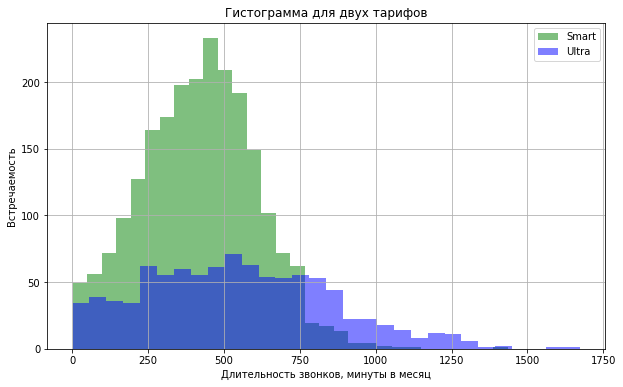

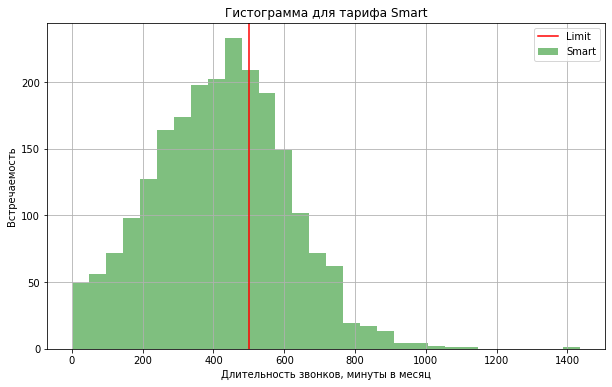

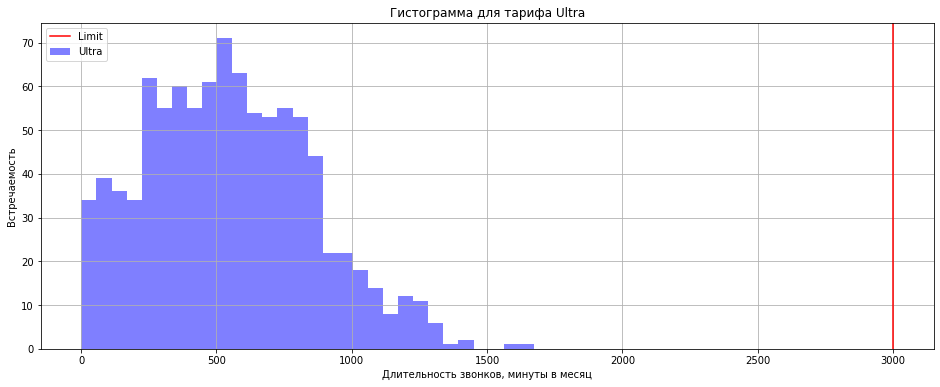

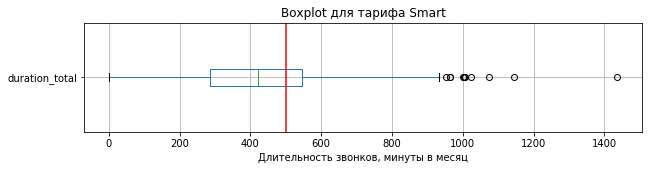

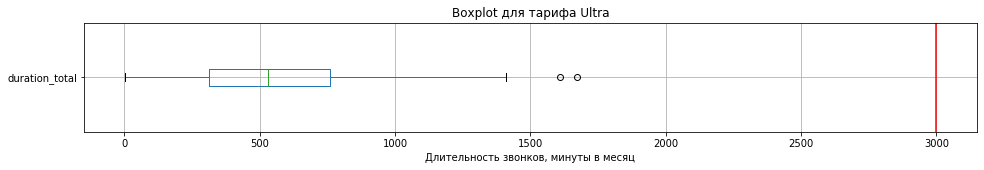

Параметры длительности звонков для тарифа Смарт:
Среднее значение: 419.44
Дисперсия: 35702.05
Стандартное отклонение: 188.95

Параметры длительности звонков для тарифа Ультра:
Среднее значение: 547.76
Дисперсия: 93239.87
Стандартное отклонение: 305.35


In [976]:
# Создадим отдельные датасеты для тарифов
data_smart = data.query('tariff == "smart"')
data_ultra = data.query('tariff == "ultra"')
print(f'Количество пользователей тарифа Смарт: {len(data_smart)}')
print(f'Количество пользователей тарифа Ультра: {len(data_ultra)}')

# Строим общую гистограмму
data_smart['duration_total'].hist(alpha=0.5, figsize=(10,6), label='Smart', bins=30, color='g')
data_ultra['duration_total'].hist(alpha=0.5, figsize=(10,6), label='Ultra', bins=30, color='b')
plt.legend()
plt.xlabel('Длительность звонков, минуты в месяц')
plt.ylabel('Встречаемость')
plt.title('Гистограмма для двух тарифов')
plt.show()

# Строим отдельные гистограммы
data_smart['duration_total'].hist(alpha=0.5, figsize=(10,6), label='Smart', bins=30, color='g')
plt.xlabel('Длительность звонков, минуты в месяц')
plt.ylabel('Встречаемость')
# Дабавляем лимит по тарифу на график. В данном случае считаю, что проще вручную,
# чем делать ссылку на соответствующую таблицу
plt.axvline(500, color='r',label='Limit')
plt.legend()
plt.title('Гистограмма для тарифа Smart')
plt.show()

data_ultra['duration_total'].hist(alpha=0.5, figsize=(16,6), label='Ultra', bins=30, color='b')
plt.xlabel('Длительность звонков, минуты в месяц')
plt.ylabel('Встречаемость')
plt.axvline(3000, color='r',label='Limit')
plt.legend()
plt.title('Гистограмма для тарифа Ultra')
plt.show()

# Строим боксплоты. Для наглядности - горизонтальные.
data_smart.boxplot(column='duration_total',vert=False,figsize=(10,2))
plt.axvline(500, color='r')
plt.title('Boxplot для тарифа Smart')
plt.xlabel('Длительность звонков, минуты в месяц')
plt.show()

data_ultra.boxplot(column='duration_total',vert=False,figsize=(16,2))
plt.axvline(3000, color='r')
plt.title('Boxplot для тарифа Ultra')
plt.xlabel('Длительность звонков, минуты в месяц')
plt.show()

# Считаем среднее, дисперсию и стандартное отклонение
duration_smart_mean = data_smart['duration_total'].mean()
duration_smart_variance = np.var(data_smart['duration_total'])
duration_smart_stan_dev = np.sqrt(duration_smart_variance)

duration_ultra_mean = data_ultra['duration_total'].mean()
duration_ultra_variance = np.var(data_ultra['duration_total'])
duration_ultra_stan_dev = np.sqrt(duration_ultra_variance)

# Выводим результаты на печать
print('Параметры длительности звонков для тарифа Смарт:')
print(f'Среднее значение: {round(duration_smart_mean,2)}')
print(f'Дисперсия: {round(duration_smart_variance,2)}')
print(f'Стандартное отклонение: {round(duration_smart_stan_dev,2)}')
print()
print('Параметры длительности звонков для тарифа Ультра:')
print(f'Среднее значение: {round(duration_ultra_mean,2)}')
print(f'Дисперсия: {round(duration_ultra_variance,2)}')
print(f'Стандартное отклонение: {round(duration_ultra_stan_dev,2)}')

#### Выводы по длительности звонков:

1. В случае обоих тарифов распределение длительности звонков похоже на нормальное. 
2. Оба распределения скошены в положительную сторону, причём в ультре скос более выраженный.
3. В среднем пользователи Ультра говорят на 25% больше. 
4. В тарифе Смарт почти половина пользователей выговаривают лимит в 500 мин, в Ультре лимит выглядит избыточночным - никто из пользователей не потратил выделенные 3000 минут.
5. Пользователи тарифа Ультра ведут себя более "разнообразно" - отклонение в их распределении больше.

### Количество звонков

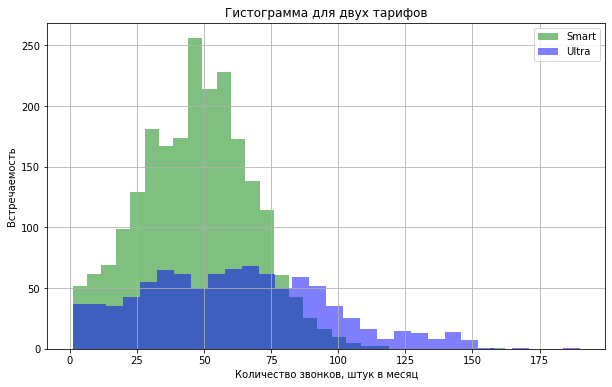

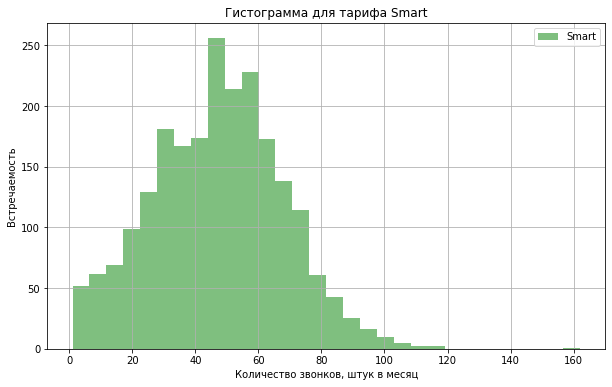

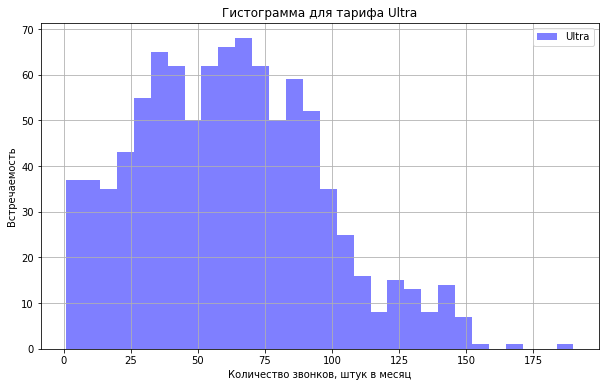

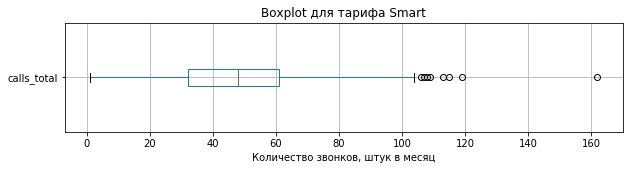

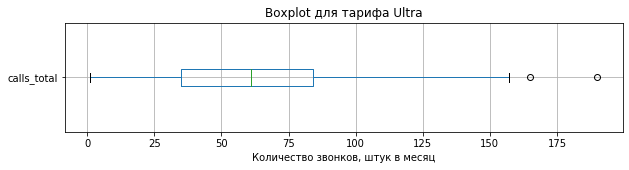

Параметры количества звонков для тарифа Смарт:
Среднее значение: 47.12
Дисперсия: 436.07
Стандартное отклонение: 20.88

Параметры количества звонков для тарифа Ультра:
Среднее значение: 61.61
Дисперсия: 1167.67
Стандартное отклонение: 34.17


In [977]:
# Строим общую гистограмму
data_smart['calls_total'].hist(alpha=0.5, figsize=(10,6), label='Smart', bins=30, color='g')
data_ultra['calls_total'].hist(alpha=0.5, figsize=(10,6), label='Ultra', bins=30, color='b')
plt.legend()
plt.xlabel('Количество звонков, штук в месяц')
plt.ylabel('Встречаемость')
plt.title('Гистограмма для двух тарифов')
plt.show()

# Строим отдельные гистограммы
data_smart['calls_total'].hist(alpha=0.5, figsize=(10,6), label='Smart', bins=30, color='g')
plt.xlabel('Количество звонков, штук в месяц')
plt.ylabel('Встречаемость')
plt.legend()
plt.title('Гистограмма для тарифа Smart')
plt.show()

data_ultra['calls_total'].hist(alpha=0.5, figsize=(10,6), label='Ultra', bins=30, color='b')
plt.xlabel('Количество звонков, штук в месяц')
plt.ylabel('Встречаемость')
plt.legend()
plt.title('Гистограмма для тарифа Ultra')
plt.show()

# Строим боксплоты. Для наглядности - горизонтальные.
data_smart.boxplot(column='calls_total',vert=False,figsize=(10,2))
plt.title('Boxplot для тарифа Smart')
plt.xlabel('Количество звонков, штук в месяц')
plt.show()

data_ultra.boxplot(column='calls_total',vert=False,figsize=(10,2))
plt.title('Boxplot для тарифа Ultra')
plt.xlabel('Количество звонков, штук в месяц')
plt.show()

# Считаем среднее, дисперсию и стандартное отклонение
calls_smart_mean = data_smart['calls_total'].mean()
calls_smart_variance = np.var(data_smart['calls_total'])
calls_smart_stan_dev = np.sqrt(calls_smart_variance)

calls_ultra_mean = data_ultra['calls_total'].mean()
calls_ultra_variance = np.var(data_ultra['calls_total'])
calls_ultra_stan_dev = np.sqrt(calls_ultra_variance)

# Выводим результаты на печать
print('Параметры количества звонков для тарифа Смарт:')
print(f'Среднее значение: {round(calls_smart_mean,2)}')
print(f'Дисперсия: {round(calls_smart_variance,2)}')
print(f'Стандартное отклонение: {round(calls_smart_stan_dev,2)}')
print()
print('Параметры количества звонков для тарифа Ультра:')
print(f'Среднее значение: {round(calls_ultra_mean,2)}')
print(f'Дисперсия: {round(calls_ultra_variance,2)}')
print(f'Стандартное отклонение: {round(calls_ultra_stan_dev,2)}')

#### Вывод по количеству звонков:

1. В случае обоих тарифов распределение количества звонков похоже на нормальное. 
2. Оба распределения скошены в положительную сторону, причём в ультре скос более выраженный.
3. В среднем пользователи Ультра совершают на 25% больше звонков. 
4. Пользователи тарифа Ультра ведут себя более "разнообразно" - согласно боксплоту есть значительное количество пользователей, совершающее более 150 звонков в месяц. Стандартное отклонение у Ультры выше в полтора раза.

### Количество смс-сообщений

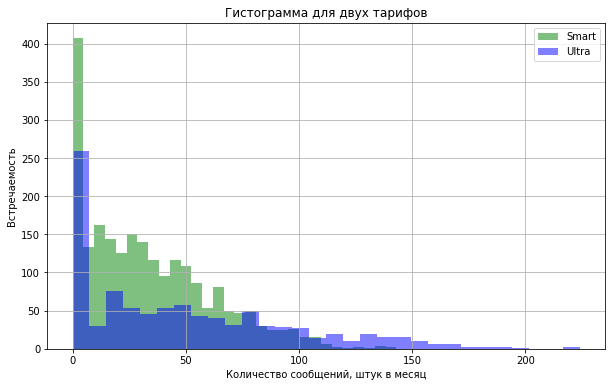

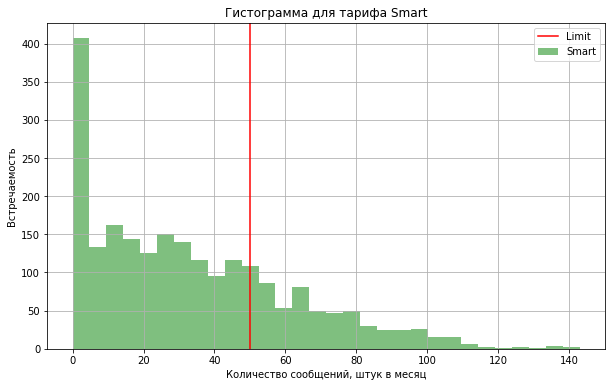

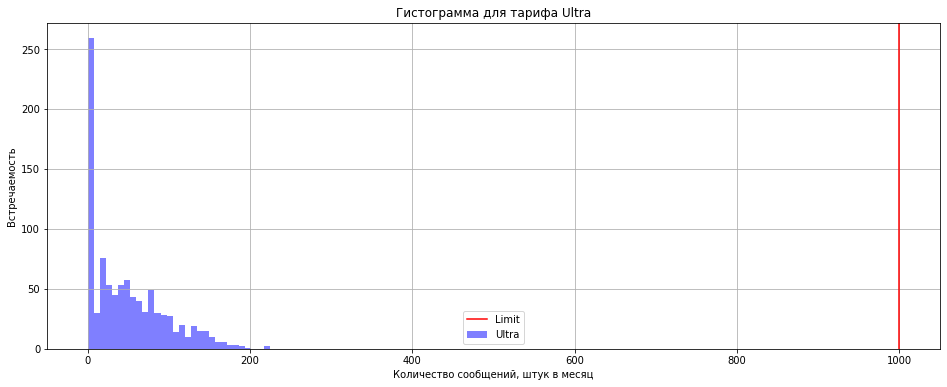

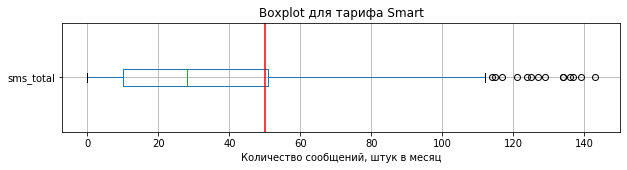

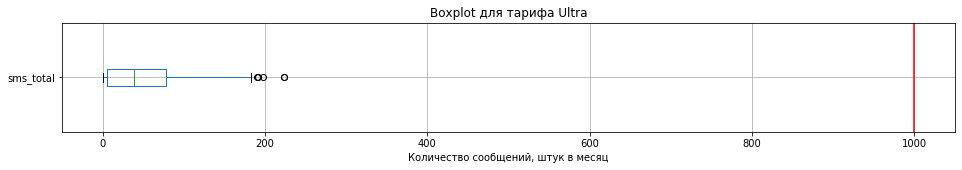

Параметры количества сообщений для тарифа Смарт:
Среднее значение: 33.39
Медиана: 28.0
Дисперсия: 798.85
Стандартное отклонение: 28.26

Параметры количества сообщений для тарифа Ультра:
Среднее значение: 48.76
Медиана: 39.0
Дисперсия: 2169.43
Стандартное отклонение: 46.58


In [978]:
# Строим общую гистограмму
data_smart['sms_total'].hist(alpha=0.5, figsize=(10,6), label='Smart', bins=30, color='g')
data_ultra['sms_total'].hist(alpha=0.5, figsize=(10,6), label='Ultra', bins=30, color='b')
plt.legend()
plt.xlabel('Количество сообщений, штук в месяц')
plt.ylabel('Встречаемость')
plt.title('Гистограмма для двух тарифов')
plt.show()

# Строим отдельные гистограммы
data_smart['sms_total'].hist(alpha=0.5, figsize=(10,6), label='Smart', bins=30, color='g')
plt.xlabel('Количество сообщений, штук в месяц')
plt.ylabel('Встречаемость')
# Дабавляем лимит по тарифу на график. В данном случае считаю, что проще вручную,
# чем делать ссылку на соответствующую таблицу
plt.axvline(50, color='r',label='Limit')
plt.legend()
plt.title('Гистограмма для тарифа Smart')
plt.show()

data_ultra['sms_total'].hist(alpha=0.5, figsize=(16,6), label='Ultra', bins=30, color='b')
plt.xlabel('Количество сообщений, штук в месяц')
plt.ylabel('Встречаемость')
plt.axvline(1000, color='r',label='Limit')
plt.legend()
plt.title('Гистограмма для тарифа Ultra')
plt.show()

# Строим боксплоты. Для наглядности - горизонтальные.
data_smart.boxplot(column='sms_total',vert=False,figsize=(10,2))
plt.axvline(50, color='r')
plt.xlabel('Количество сообщений, штук в месяц')
plt.title('Boxplot для тарифа Smart')
plt.show()

data_ultra.boxplot(column='sms_total',vert=False,figsize=(16,2))
plt.axvline(1000, color='r')
plt.title('Boxplot для тарифа Ultra')
plt.xlabel('Количество сообщений, штук в месяц')
plt.show()

# Считаем среднее, дисперсию и стандартное отклонение, в данном случае так же добавим медиану
sms_smart_mean = data_smart['sms_total'].mean()
sms_smart_median = data_smart['sms_total'].median()
sms_smart_variance = np.var(data_smart['sms_total'])
sms_smart_stan_dev = np.sqrt(sms_smart_variance)

sms_ultra_mean = data_ultra['sms_total'].mean()
sms_ultra_median = data_ultra['sms_total'].median()
sms_ultra_variance = np.var(data_ultra['sms_total'])
sms_ultra_stan_dev = np.sqrt(sms_ultra_variance)

# Выводим результаты на печать
print('Параметры количества сообщений для тарифа Смарт:')
print(f'Среднее значение: {round(sms_smart_mean,2)}')
print(f'Медиана: {round(sms_smart_median,2)}')
print(f'Дисперсия: {round(sms_smart_variance,2)}')
print(f'Стандартное отклонение: {round(sms_smart_stan_dev,2)}')
print()
print('Параметры количества сообщений для тарифа Ультра:')
print(f'Среднее значение: {round(sms_ultra_mean,2)}')
print(f'Медиана: {round(sms_ultra_median,2)}')
print(f'Дисперсия: {round(sms_ultra_variance,2)}')
print(f'Стандартное отклонение: {round(sms_ultra_stan_dev,2)}')

#### Вывод по количеству сообщений:

1. СМС-сообщение постепенно перестают терять популярность - значительное количество пользователей обоих тарифов пользуются ими минимально либо не пользуются вообще.
2. Распределения вряд ли можно охарактеризовать, как нормальные. Ближе к распределению Пуассона. 
3. В среднем, пользователи Ультра отправляют в полтора раза больше сообщений.
4. Вновь пользователи Ультра ведут себя более разнообразно, отклонение выше в полтора раза.
5. Больше половины пользователей Смарт укладываются в заданный лимит в 50 сообщений, но весомая часть его превышает.
6. Лимит в 1000 сообщений в случае Ультра выглядит совершенно ненужным. На боксплоте это видно наглядно.

### Интернет-трафик

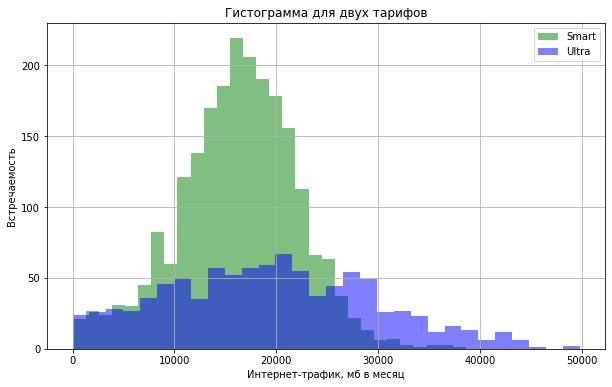

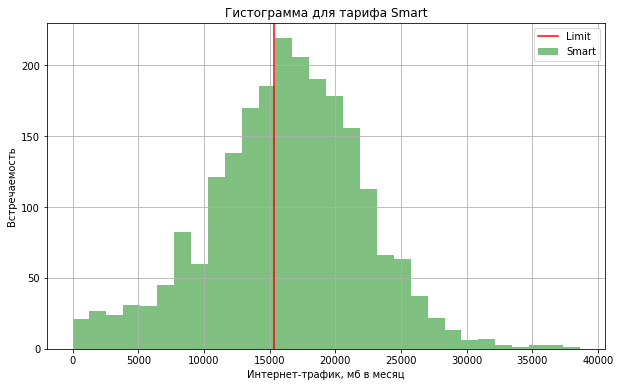

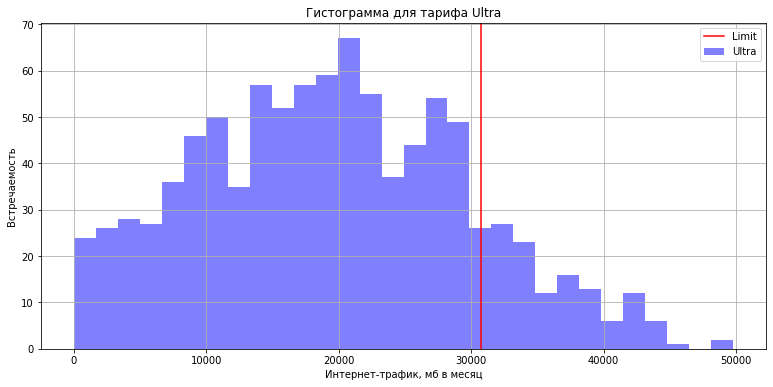

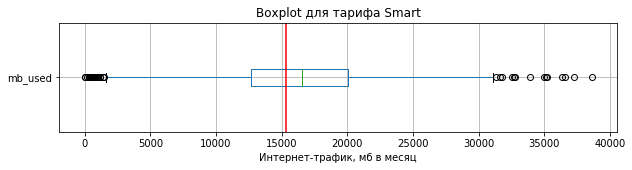

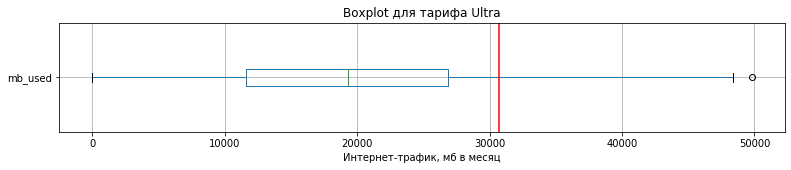

Параметры интернет-трафика для тарифа Смарт:
Среднее значение: 16231.46
Медиана: 16527.0
Дисперсия: 34599364.85
Стандартное отклонение: 5882.12

Параметры интернет-трафика для тарифа Ультра:
Среднее значение: 19489.67
Медиана: 19335.0
Дисперсия: 102650986.32
Стандартное отклонение: 10131.68


In [979]:
# Строим общую гистограмму
data_smart['mb_used'].hist(alpha=0.5, figsize=(10,6), label='Smart', bins=30, color='g')
data_ultra['mb_used'].hist(alpha=0.5, figsize=(10,6), label='Ultra', bins=30, color='b')
plt.legend()
plt.xlabel('Интернет-трафик, мб в месяц')
plt.ylabel('Встречаемость')
plt.title('Гистограмма для двух тарифов')
plt.show()

# Строим отдельные гистограммы
data_smart['mb_used'].hist(alpha=0.5, figsize=(10,6), label='Smart', bins=30, color='g')
plt.xlabel('Интернет-трафик, мб в месяц')
plt.ylabel('Встречаемость')
# Дабавляем лимит по тарифу на график. В данном случае считаю, что проще вручную,
# чем делать ссылку на соответствующую таблицу
plt.axvline(15360, color='r',label='Limit')
plt.legend()
plt.title('Гистограмма для тарифа Smart')
plt.show()

data_ultra['mb_used'].hist(alpha=0.5, figsize=(13,6), label='Ultra', bins=30, color='b')
plt.xlabel('Интернет-трафик, мб в месяц')
plt.ylabel('Встречаемость')
plt.axvline(30720, color='r',label='Limit')
plt.legend()
plt.title('Гистограмма для тарифа Ultra')
plt.show()

# Строим боксплоты. Для наглядности - горизонтальные.
data_smart.boxplot(column='mb_used',vert=False,figsize=(10,2))
plt.axvline(15360, color='r')
plt.title('Boxplot для тарифа Smart')
plt.xlabel('Интернет-трафик, мб в месяц')
plt.show()

data_ultra.boxplot(column='mb_used',vert=False,figsize=(13,2))
plt.axvline(30720, color='r')
plt.title('Boxplot для тарифа Ultra')
plt.xlabel('Интернет-трафик, мб в месяц')
plt.show()

# Считаем среднее, дисперсию и стандартное отклонение, в данном случае так же добавим медиану
traffic_smart_mean = data_smart['mb_used'].mean()
traffic_smart_median = data_smart['mb_used'].median()
traffic_smart_variance = np.var(data_smart['mb_used'])
traffic_smart_stan_dev = np.sqrt(traffic_smart_variance)

traffic_ultra_mean = data_ultra['mb_used'].mean()
traffic_ultra_median = data_ultra['mb_used'].median()
traffic_ultra_variance = np.var(data_ultra['mb_used'])
traffic_ultra_stan_dev = np.sqrt(traffic_ultra_variance)

# Выводим результаты на печать
print('Параметры интернет-трафика для тарифа Смарт:')
print(f'Среднее значение: {round(traffic_smart_mean,2)}')
print(f'Медиана: {round(traffic_smart_median,2)}')
print(f'Дисперсия: {round(traffic_smart_variance,2)}')
print(f'Стандартное отклонение: {round(traffic_smart_stan_dev,2)}')
print()
print('Параметры интернет-трафика для тарифа Ультра:')
print(f'Среднее значение: {round(traffic_ultra_mean,2)}')
print(f'Медиана: {round(traffic_ultra_median,2)}')
print(f'Дисперсия: {round(traffic_ultra_variance,2)}')
print(f'Стандартное отклонение: {round(traffic_ultra_stan_dev,2)}')

#### Вывод по интернет-трафику:

1. Оба распределения нормальные, у Смарта более выраженное (медиана почти равна среднему)- стандартное отклонение меньше вдвое в сравнении с Ультра.
2. Пользователи Ультра расходуют примерно на 20% больше трафика.
3. Большинство пользователей Смарт превышают лимит в 15 гб.
4. Большинство пользователей Ультра укладываются в лимитированные 30 гб, но весомая часть превышает.

### Вывод по анализу данных (Шагу 3)

1. Поведение пользователей Смарт ближе к нормальному распределению.
2. Пользователи Ультра расходуют минуты, интернет и сообщения на 20..25% активнее пользователей Смарт.
3. Пользователи Ультра ведут себя более разнообразно. Многие пользователи не используют весь потенциал тарифа и, возможно, им было бы достаточно лимитов Смарта, но есть пользователи, для которых большие пакеты действительно нужны.
4. Наиболее активно с точки зрения превышения лимитов люди пользуются интернетом. Вероятно, для телеком компании этот параметр и является основным источником дохода сверх абонентской платы.

### Проверка гипотез (Шаг 4)

#### Средняя выручка Ультра и Смарт

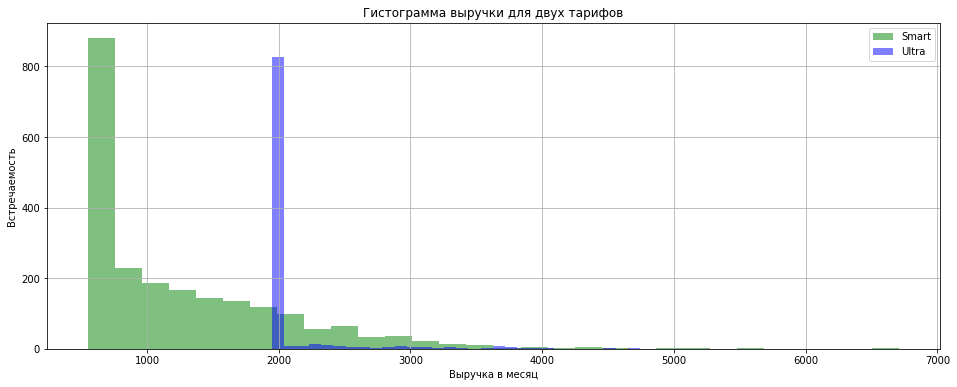

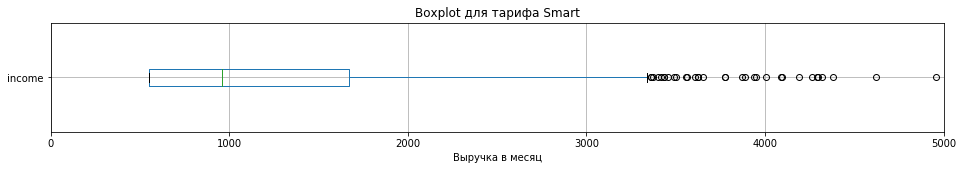

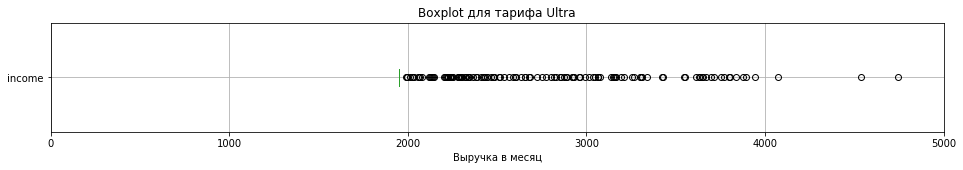

In [980]:
smart_income = data_smart['income']
ultra_income = data_ultra['income']

smart_income.hist(alpha=0.5, figsize=(16,6), label='Smart', bins=30, color='g')
ultra_income.hist(alpha=0.5, figsize=(16,6), label='Ultra', bins=30, color='b')
plt.legend()
plt.xlabel('Выручка в месяц')
plt.ylabel('Встречаемость')
plt.title('Гистограмма выручки для двух тарифов')
plt.show()

# Строим боксплоты. Для наглядности - горизонтальные.
data_smart.boxplot(column='income',vert=False,figsize=(16,2))
plt.xlim(0,5000)
plt.title('Boxplot для тарифа Smart')
plt.xlabel('Выручка в месяц')
plt.show()

data_ultra.boxplot(column='income',vert=False,figsize=(16,2))
plt.xlim(0,5000)
plt.title('Boxplot для тарифа Ultra')
plt.xlabel('Выручка в месяц')
plt.show()

In [981]:
# Проверим соотношение дисперсий этих выборок
income_smart_variance = np.var(data_smart['income'])
income_ultra_variance = np.var(data_ultra['income'])
print(f'Дисперсия по тарифу Смарт равна {round(income_smart_variance,2)}')
print(f'Дисперсия по тарифу Ультра равна {round(income_ultra_variance,2)}')

Дисперсия по тарифу Смарт равна 621610.21
Дисперсия по тарифу Ультра равна 129569.86


In [982]:
# Примем нулевую гипотезу о равенстве двух средних, при её отвержении будем считать средние различающимися
# Альфу принимаем 0.05 как для двухсторонней гипотезы

alpha = 0.05 

results = st.ttest_ind(
    smart_income, 
    ultra_income, 
#     Дисперсии различаются, поэтому:
    equal_var = False)

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.2270215415187496e-289
Отвергаем нулевую гипотезу


Нулевая гипотеза о равенстве средних выручек по тарифам Смарт и Ультра отвергнута. Это подтверждается графиками - выручка тарифа Ультра значительно выше.

#### Средняя выручка Москвы и регионов

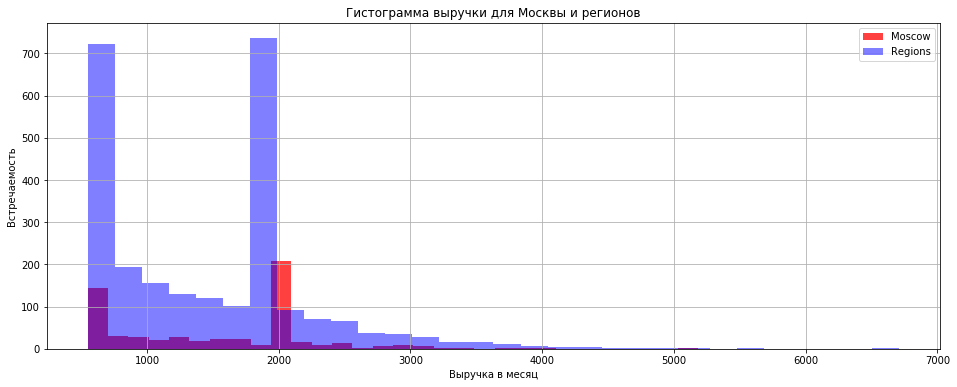

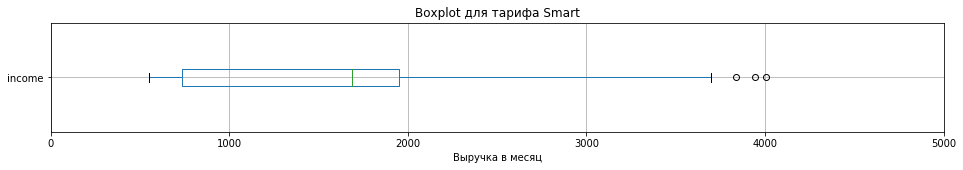

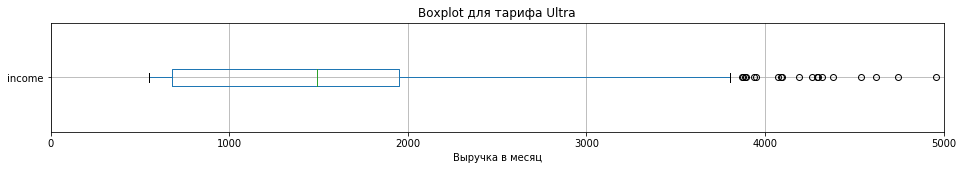

In [983]:
moscow = data.query('city == "Москва"')
regions = data.query('city != "Москва"')

moscow_income = moscow['income']
regions_income = regions['income']

moscow_income.hist(alpha=0.75, figsize=(16,6), label='Moscow', bins=30, color='r')
regions_income.hist(alpha=0.5, figsize=(16,6), label='Regions', bins=30, color='b')
plt.legend()
plt.xlabel('Выручка в месяц')
plt.ylabel('Встречаемость')
plt.title('Гистограмма выручки для Москвы и регионов')
plt.show()

# Строим боксплоты. Для наглядности - горизонтальные.
moscow.boxplot(column='income',vert=False,figsize=(16,2))
plt.xlim(0,5000)
plt.title('Boxplot для тарифа Smart')
plt.xlabel('Выручка в месяц')
plt.show()

regions.boxplot(column='income',vert=False,figsize=(16,2))
plt.xlim(0,5000)
plt.title('Boxplot для тарифа Ultra')
plt.xlabel('Выручка в месяц')
plt.show()

In [984]:
income_moscow_variance = np.var(moscow_income)
income_regions_variance = np.var(regions_income)
print(f'Дисперсия по Москве равна {round(income_moscow_variance,2)}')
print(f'Дисперсия по регионам равна {round(income_regions_variance,2)}')

Дисперсия по Москве равна 546920.9
Дисперсия по регионам равна 634796.0


In [985]:
alpha = 0.05 

results = st.ttest_ind(
    moscow_income, 
    regions_income, 
#     Здесь дисперсии близки, поэтому:
    equal_var = True)

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.38741872566119906
Не получилось отвергнуть нулевую гипотезу


Гипотеза о равенстве средних выручек в Москве и регоинах не была отвержена. Проверим равенство среднего по регионам среднему по Москве методом сравнения с числом.

In [986]:
# За сравниваемое число примем среднюю выручку по Москве
mean_value = moscow_income.mean()

alpha = 0.05

results = st.ttest_1samp(
    regions_income, 
    mean_value)

print('p-значение: ', results.pvalue) # введите ваш код тут)

if (results.pvalue < alpha) :# введите ваш код тут):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.05203444014491089
Не получилось отвергнуть нулевую гипотезу


Гипотеза вновь не отвержена. Таким образом, считаем средние выручки по Москве и регионам равными с допустимой погрешностью, что подтверждается графиками.

### Вывод по проверке гипотез (Шагу 4)

1. Средняя выручка Ультра и Смарт различается - подтверждено.
2. Средняя выручка по Москве и регионам различиается - не подтверждено.

## Общий вывод

В ходе работы над проектом проделаны следующие этапы:
1. Импортированы данные из нескольких датасетов.
2. Данные обработаны, создана сводная таблица, посчитаны недостающие параметры.
3. Изучены параметры: длительность и количество звонков, количество сообщений и потраченный трафик каждым пользователем помесячно.
4. Изучены средние выручки по разным тарифам и по разным регионам.

Сделаны следующие выводы:
1. Наиболее расходуемым элементом тарифных пакетов является интернет-трафик.
2. Сообщения востребованы пользователями в меньшей степени.
3. В целом, пользователи тарифа Ультра расходуют больше интернета, минут и сообщений, однако эта разница непропорциональна лимитам тарифа и разнице в абонентской плате.
4. С точки зрения средней выручки тариф Ультра является более выгодным для Телеком-компании.
5. Средняя выручка по Москве и регионам различается незначительно.